# Inverse Splitter using topology optimization

MEEP simulation for inverse splitter

In [1]:
from functools import partial
from pathlib import Path
import gdsfactory as gf
import jax
import glob
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sax
import meep as mp
import gplugins
import gplugins.gmeep as gm
from meep import MaterialGrid, Medium, Vector3, Volume
from meep.adjoint import (
    DesignRegion,
    get_conic_radius_from_eta_e,
)
from autograd import numpy as npa, tensor_jacobian_product, grad
import gplugins.tidy3d as gt
from gplugins.common.config import PATH
import inspect
import meep.adjoint as mpa
from matplotlib.animation import FuncAnimation, PillowWriter
import os

Using MPI version 4.1, 1 processes
2025-12-09 15:09:19.498 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


In [4]:
neffs_TCAD = np.load("neffs_TCAD.npy", allow_pickle=True)  

In [5]:
neffs_TCAD

array({0: np.complex128(2.579233149832461+4.2558454254802517e-05j), -0.5: np.complex128(2.579248605051533+4.20043472854569e-05j), -1: np.complex128(2.5792605310824923+4.1578101252069765e-05j), -1.5: np.complex128(2.5792684479189205+4.1298845722944675e-05j), -2: np.complex128(2.5792768911186554+4.100265496131908e-05j), -2.5: np.complex128(2.579284107736812+4.0752849952389265e-05j), -3.5: np.complex128(2.5792960309736594+4.033633789155556e-05j), -4: np.complex128(2.57930195707953+4.012628342291738e-05j), -5: np.complex128(2.5793103370214245+3.9827958190374006e-05j), -6: np.complex128(2.5793178726112416+3.956270654250005e-05j), -7: np.complex128(2.579323275257858+3.935982457145146e-05j), -9: np.complex128(2.5793333855608185+3.901735265199731e-05j), -10: np.complex128(2.5793378293861204+3.888440364347489e-05j)},
      dtype=object)

## Simple ybranch from gdsfactory

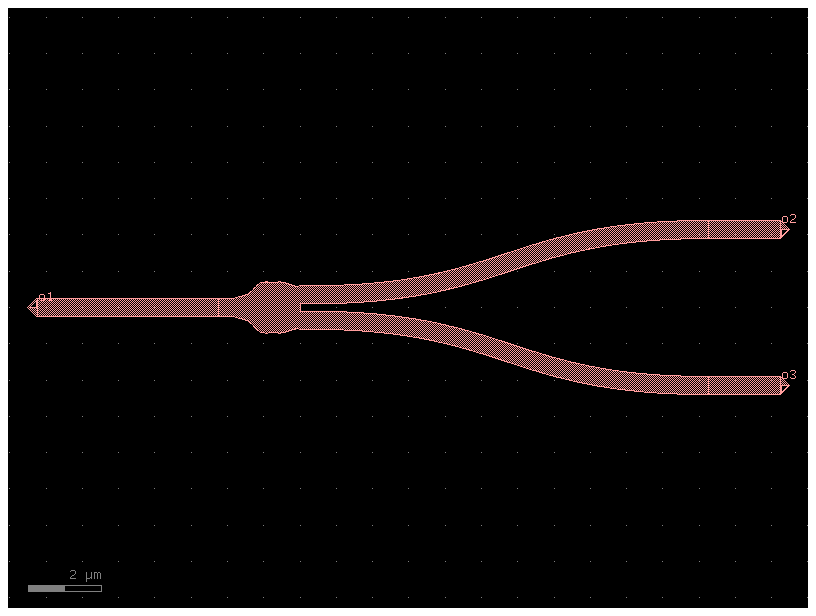

In [2]:
gf.clear_cache()
ybranch = gf.Component("ybranch")

inwg = gf.components.straight(length=5)
outwg = gf.components.straight(length=2)
splitter = gf.components.mmi1x2_with_sbend()

inwg_ref = ybranch.add_ref(inwg)
splitter_ref = ybranch.add_ref(splitter)
outwg_top_ref = ybranch.add_ref(outwg)
outwg_bot_ref = ybranch.add_ref(outwg)

# Connecting ports
inwg_ref.connect("o2", splitter_ref.ports["o1"])
outwg_top_ref.connect("o1", splitter_ref.ports["o2"])
outwg_bot_ref.connect("o1", splitter_ref.ports["o3"])

# adding port name
ybranch.add_port(name=f"o1", port=inwg_ref.ports["o1"])
ybranch.add_port(name=f"o2", port=outwg_top_ref.ports["o2"])
ybranch.add_port(name=f"o3", port=outwg_bot_ref.ports["o2"])
ybranch.auto_rename_ports()

# plotting
ybranch.draw_ports()
ybranch.plot()

# Inverse design of the splitter

In [3]:
design_region_width = 2.5
design_region_height = 2.5

eta_e = 0.55
minimum_length = 0.1
filter_radius = get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

resolution = 20
design_region_resolution = int(5 * resolution)

Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

pml_size = 1.0
waveguide_length = 1.5
waveguide_width = 0.5
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
Sy = 2 * pml_size + design_region_height + 0.5
cell_size = (Sx, Sy)

SiO2 = Medium(index=1.44)
Si = Medium(index=3.4)

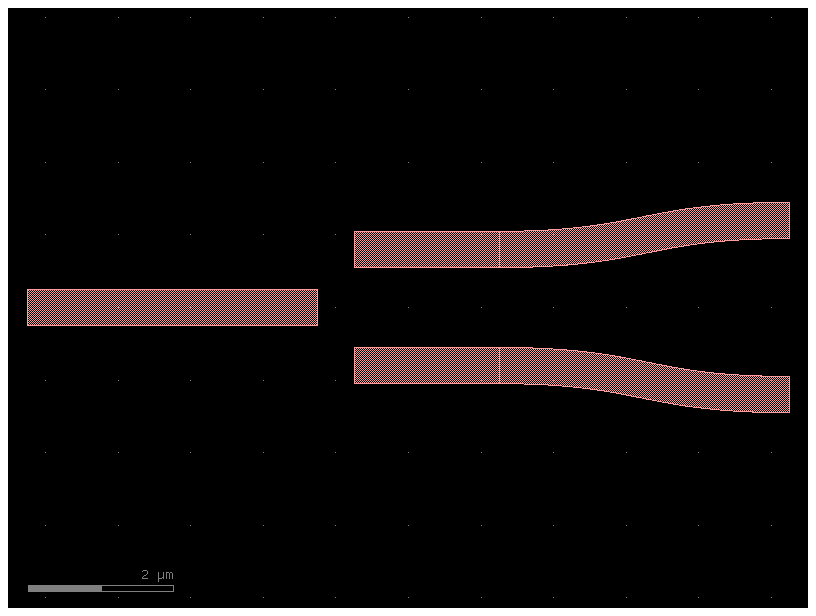

In [4]:
# Get the correct dimensions from conic_filter's mesh_grid
from meep.adjoint.filters import mesh_grid
Nx_filter, Ny_filter, _, _ = mesh_grid(get_conic_radius_from_eta_e(minimum_length, eta_e), design_region_width, design_region_height, design_region_resolution)

design_variables = MaterialGrid(Vector3(Nx_filter, Ny_filter), SiO2, Si, grid_type="U_MEAN")
design_region = DesignRegion(
    design_variables,
    volume=Volume(
        center=Vector3(),
        size=Vector3(design_region_width, design_region_height, 0),
    ),
)

c = gf.Component()

arm_separation = 1.0
straight1 = c << gf.components.straight(length=4, cross_section='strip')
straight1.dmove(straight1.ports["o2"].dcenter, (-design_region_width / 2.0, 0))
straight2 = c << gf.components.straight(length=2, cross_section='strip')
straight2.dmove(straight2.ports["o2"].dcenter, (design_region_width / 2.0, 0.8))
bend2 = c << gf.components.bend_s(size=(4,0.4),cross_section='strip')
bend2.connect("o1", straight2.ports["o2"])
straight3 = c << gf.components.straight(length=2, cross_section='strip')
straight3.dmove(straight3.ports["o2"].dcenter, (design_region_width / 2.0, -0.8))
bend3 = c << gf.components.bend_s(size=(4,0.4),cross_section='strip').copy()
bend3.mirror_y()
bend3.connect("o1", straight3.ports["o2"])

# bend3.dmove(straight3.ports["o1"].dcenter, (design_region_width / 2.0, -1))

c.add_port("o1", port=straight1.ports["o1"])
c.add_port("o2", port=bend2.ports["o2"])
c.add_port("o3", port=bend3.ports["o2"])
# c.draw_ports()
c.plot()

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4446: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


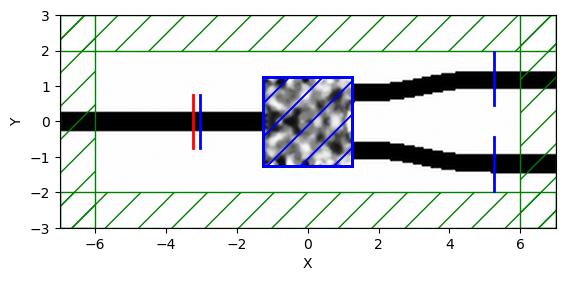

In [ ]:
def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()


seed = 240
np.random.seed(seed)

# Get the correct dimensions from conic_filter's mesh_grid
from meep.adjoint.filters import mesh_grid
Nx_filter, Ny_filter, _, _ = mesh_grid(filter_radius, design_region_width, design_region_height, design_region_resolution)

x0 = mapping(
    np.random.rand(Nx_filter * Ny_filter),
    eta_i,
    128,
)


def J(source, top, bottom):
    """
    Objective function: Maximize total transmission to both output ports
    
    CRITICAL FIX: Previous version divided by source, creating a ratio metric
    that doesn't optimize for maximum absolute transmission.
    Now we maximize the actual power transmitted.
    """
    # Calculate absolute power at each output
    power_top = npa.abs(top) ** 2
    power_bottom = npa.abs(bottom) ** 2
    
    # Total transmitted power (this is what we want to maximize)
    total_power = power_top + power_bottom
    
    # penalize imbalance to encourage 50/50 splitting
    imbalance_penalty = 0.1 * npa.mean(npa.abs(power_top - power_bottom))
    return npa.mean(total_power) - imbalance_penalty
    
    # return npa.mean(total_power)

resolution=20
opt = gm.get_meep_adjoint_optimizer(
    c,
    J,
    [design_region],
    [design_variables],
    x0,
    resolution=resolution,
    cell_size=(
        Sx + 2 + design_region_width + 2 * pml_size,
        design_region_height + 2 * pml_size + 1.5,
    ),
    tpml=1.0,
    extend_ports_length=4.0,  # Extend ports to create space for sources/monitors
    port_margin=0.5,
    port_source_offset=-2,  # Place sources just inside the extended ports
    port_monitor_offset=-0,  # Place monitors slightly further in
    symmetries=[mp.Mirror(direction=mp.Y)],
    wavelength_points=10,
)

In [6]:
evaluation_history = []
cur_iter = [0]

# Create directory for saving frames
os.makedirs('optimization_frames_2', exist_ok=True)

def f(v, gradient, cur_beta):
    print(f"Current iteration: {cur_iter[0] + 1}")

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    # Save the design plot as an image instead of showing it
    fig, ax = plt.subplots(figsize=(10, 8))
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=True,
        plot_monitors_flag=True,
        plot_boundaries_flag=False,
    )
    ax.set_title(f'Iteration {cur_iter[0] + 1}, FOM: {np.max(np.real(f0)):.4f}')
    plt.savefig(f'optimization_frames_2/design_{cur_iter[0]:04d}.png', dpi=100, bbox_inches='tight')
    plt.close(fig)

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [7]:
# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx_filter)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny_filter)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

# IMPORTANT: Check that arm_separation matches the actual output positions
# Input at y=0, outputs at y=±1
arm_separation = 1.0

# Define the core mask - these waveguides should be FIXED to silicon
# Input waveguide at center (y=0)
left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)

# Output waveguides at y=+1 and y=-1
# Top output: centered at y=+arm_separation
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation) <= waveguide_width / 2
)
# Bottom output: centered at y=-arm_separation  
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation) <= waveguide_width / 2
)
Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

# Define the cladding mask - these should be FIXED to SiO2
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

# Debug: Print mask statistics
print(f"Design region: {design_region_width} x {design_region_height} um")
print(f"Grid size: {Nx_filter} x {Ny_filter}")
print(f"Si pixels (fixed): {np.sum(Si_mask)} ({100*np.sum(Si_mask)/Si_mask.size:.2f}%)")
print(f"SiO2 pixels (fixed): {np.sum(SiO2_mask)} ({100*np.sum(SiO2_mask)/SiO2_mask.size:.2f}%)")
print(f"Free pixels: {np.sum(~Si_mask & ~SiO2_mask)} ({100*np.sum(~Si_mask & ~SiO2_mask)/Si_mask.size:.2f}%)")

Design region: 2.5 x 2.5 um
Grid size: 251 x 251
Si pixels (fixed): 153 (0.24%)
SiO2 pixels (fixed): 847 (1.34%)
Free pixels: 62001 (98.41%)


Starting optimization with 72 total iterations
Beta schedule: 4 -> 128

Beta iteration 1/6, current beta: 4
Current iteration: 1
Starting forward run...


/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4440: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep.create_structure(cell_size, dft_data_list_, pml_1d_vols_, pml_2d_vols_, pml_3d_vols_, absorber_vols_, gv, br, sym, num_chunks, Courant, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_s, output_chunk_costs, my_bp)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4443: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._set_materials(s, cell_size, gv, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_geps, output_chunk_costs, my_bp)


Starting adjoint run...


/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/autograd/tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Calculating gradient...


/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/visualization.py:971: UserWarning: plot_sources_flag is deprecated. Use show_sources instead.
  warnings.warn("plot_sources_flag is deprecated. " "Use show_sources instead.")
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/visualization.py:976: UserWarning: plot_monitors_flag is deprecated. Use show_monitors instead.
  warnings.warn("plot_monitors_flag is deprecated. Use show_monitors " "instead.")


Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 12
Starting forward run...
Starting adjoint run..

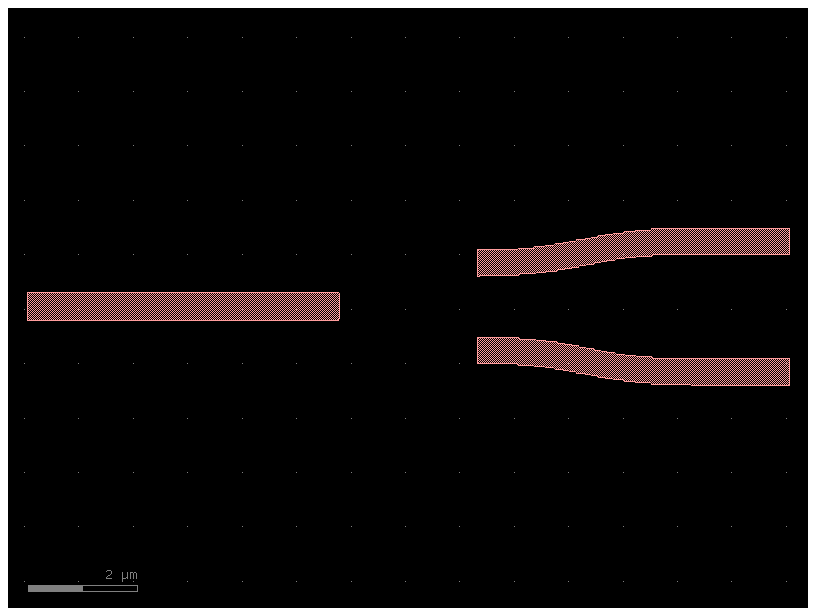

In [8]:
n = Nx_filter * Ny_filter  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx_filter * Ny_filter,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx_filter * Ny_filter,))
ub[SiO2_mask.flatten()] = 0

# IMPROVED OPTIMIZATION PARAMETERS
# Start with lower beta for better exploration
cur_beta = 4  # Changed from 4 to 2 (gentler start)
beta_scale = 2
num_betas = 6  # Changed from 7 to 8 (more gradual increase)
update_factor = 12 # Changed from 12 to 30 (MORE ITERATIONS per beta!)
# Total iterations: 8 * 30 = 240 (was only 84 before)

run_optimization = True

if run_optimization:
    print(f"Starting optimization with {num_betas * update_factor} total iterations")
    print(f"Beta schedule: {cur_beta} -> {cur_beta * (beta_scale ** (num_betas - 1))}")
    
    for iters in range(num_betas):
        print(f"\n{'='*70}")
        print(f"Beta iteration {iters+1}/{num_betas}, current beta: {cur_beta}")
        print(f"{'='*70}")

        if iters != num_betas - 1:
            x[:] = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
            )
        else:
            optimized_component = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
                get_optimized_component=True,
                opt=opt,
                threshold_offset_from_max=0.09,
            )
        cur_beta = cur_beta * beta_scale

    optimized_component.plot()
    
    # Calculate final FOM
    final_fom = np.array(evaluation_history[-1])
    final_transmission = np.mean(final_fom)
    final_figure_of_merit_dB = 10 * np.log10(0.5 * final_transmission)
    
    print(f"\n{'='*70}")
    print(f"OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Final transmission: {final_transmission:.4f} ({final_transmission*100:.2f}%)")
    print(f"Expected insertion loss: ~{-10*np.log10(final_transmission):.2f} dB")
    print(f"Final FOM (per port): {final_figure_of_merit_dB:.2f} dB")
    print(f"Total iterations: {len(evaluation_history)}")
    print(f"{'='*70}")

2025-12-08 23:23:25.345 | WARNING  | kfactory.kcell:show:4100 - klive didn't send data, closing


PosixPath('opt_device_with_ports_new_2.gds')

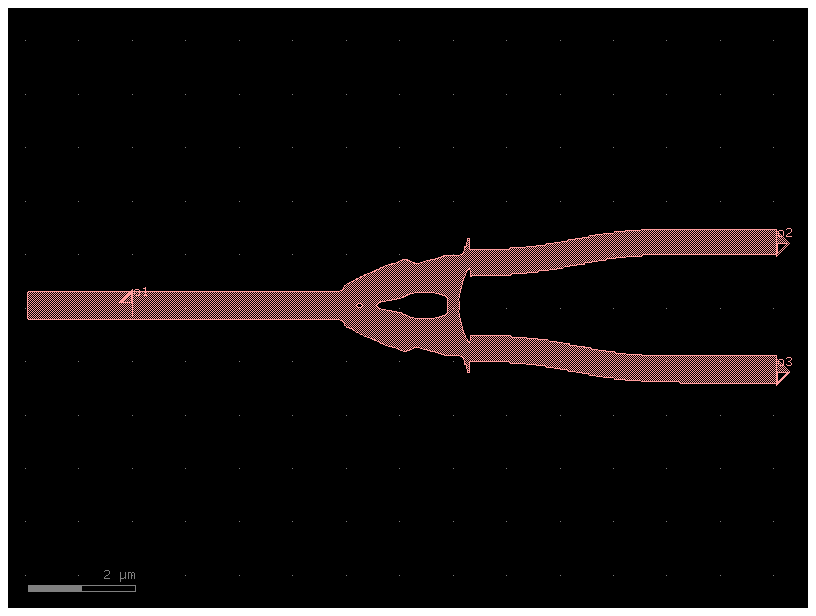

In [13]:
opt_device = gm.meep_adjoint_optimization.get_component_from_sim(opt.sim)

# Manually add ports at the waveguide ends
# Adjust these coordinates to match your actual waveguide positions
opt_device.add_port(
    name="o1",
    center=(2, 3.1),  # Input port - adjust x, y as needed
    width=0.5,
    orientation=180, cross_section='strip'
)

opt_device.add_port(
    name="o2", 
    center=(14.05, 4.21),  # Top output port - adjust x, y as needed
    width=0.5,
    orientation=0, cross_section='strip'
)

opt_device.add_port(
    name="o3",
    center=(14.05, 1.8),  # Bottom output port - adjust x, y as needed
    width=0.5,
    orientation=0, cross_section='strip'
)

opt_device.draw_ports()
opt_device.plot()
opt_device.show()

opt_device.write_gds("opt_device_with_ports_new_2.gds")

# Create Animation Videos

Create animated GIFs/videos showing the optimization progress

Combined animation saved as 'optimization_combined.gif'


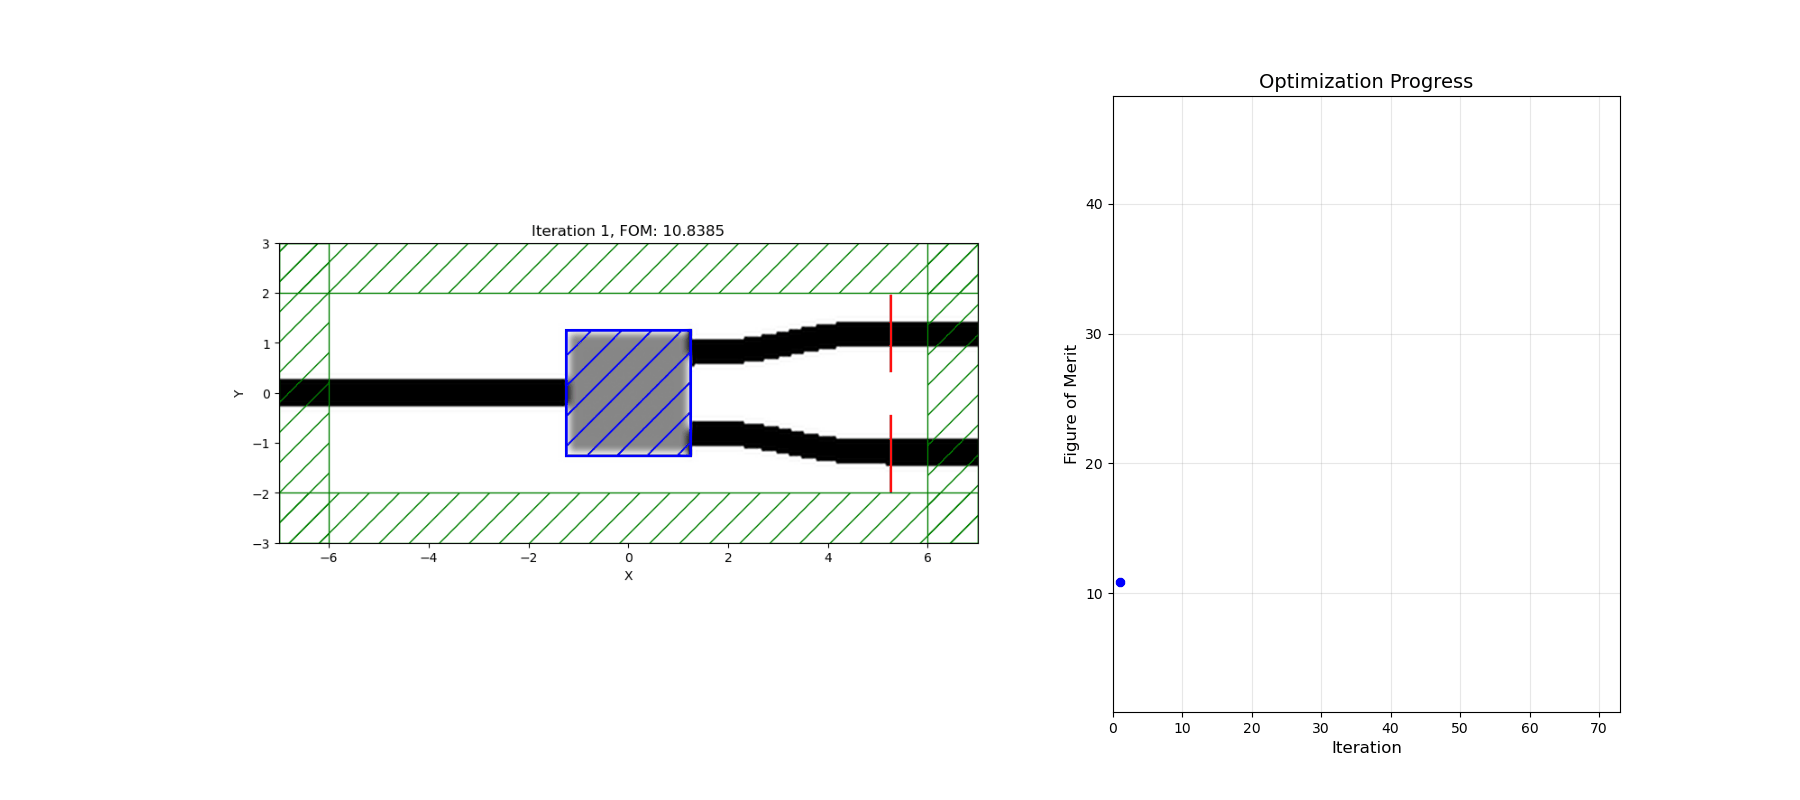

In [11]:
# Create combined animation showing both design and FOM
import matplotlib.gridspec as gridspec
from IPython.display import Image as IPImage
frame_files = sorted(glob.glob('optimization_frames_2/design_*.png'))

if len(frame_files) > 0 and len(evaluation_history) > 0:
    fig = plt.figure(figsize=(18, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

    ax1 = plt.subplot(gs[0])  # Design
    ax2 = plt.subplot(gs[1])  # FOM plot

    ax1.axis('off')

    # Load first image
    img = Image.open(frame_files[0])
    im = ax1.imshow(img)

    line, = ax2.plot([], [], 'b-o', linewidth=2, markersize=6)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Figure of Merit', fontsize=12)
    ax2.set_title('Optimization Progress', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, len(evaluation_history) + 1)
    y_min = min(evaluation_history) * 0.95
    y_max = max(evaluation_history) * 1.05
    ax2.set_ylim(y_min, y_max)

    def update_combined(frame_idx):
        # Update design image
        img = Image.open(frame_files[frame_idx])
        im.set_data(img)

        # Update FOM plot
        x_data = range(1, frame_idx + 2)
        y_data = evaluation_history[:frame_idx + 1]
        line.set_data(x_data, y_data)

        return [im, line]

    anim_combined = FuncAnimation(fig, update_combined, frames=len(frame_files),
                                  interval=200, blit=True, repeat=True)

    # Save as GIF
    writer = PillowWriter(fps=5)
    anim_combined.save('optimization_combined_3.gif', writer=writer, dpi=100)
    plt.close()

    print("Combined animation saved as 'optimization_combined.gif'")

    # Display the animation
    display(IPImage(filename='optimization_combined_3.gif'))
else:
    print("Missing data for combined animation.")

TODO calcualte the sparammeter for the inverse design and the generic design and compare them. 

Next, build a compact model for the inverse design and then make an mzi 

2025-12-08 23:23:30.943 | ERROR    | kfactory.kcell:name:687 - Name conflict in kfactory.kcell::name at line 687
Renaming Unnamed_32 (cell_index=32) to Unnamed_31 would cause it to be named the same as:
 - Unnamed_31 (cell_index=31), function_name=None, basename=None


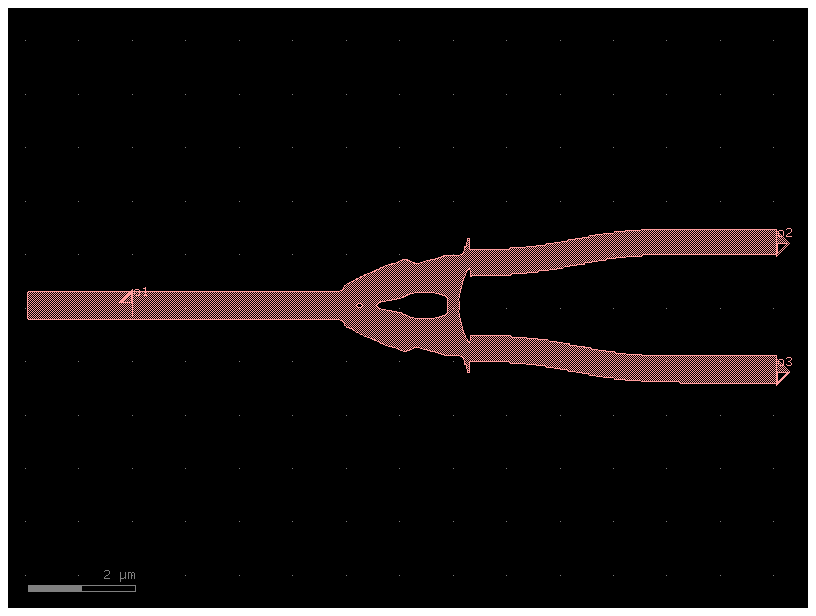

In [14]:
opt_device = gf.import_gds(gdspath="opt_device_with_ports_new_2.gds")
opt_device.plot()

MEEP FDTD simualtion to do sparameter extraction

In [15]:

wavelengths = np.linspace(1.5, 1.6, 50)
lda_c = wavelengths[wavelengths.size // 2]

pdk = gf.get_active_pdk()


layer_stack = pdk.get_layer_stack()
core = layer_stack.layers["core"]
clad = layer_stack.layers["clad"]
box = layer_stack.layers["box"]

layer_stack.layers.pop("substrate", None)

print(
    f"""Stack:
- {clad.material} clad with {clad.thickness}µm
- {core.material} clad with {core.thickness}µm
- {box.material} clad with {box.thickness}µm"""
)

Stack:
- sio2 clad with 3.0µm
- si clad with 0.22µm
- sio2 clad with 3.0µm


2.5D using effective index

In [16]:
core_material = gplugins.get_effective_indices(
    core_material=3.4777,
    clad_materialding=1.444,
    nsubstrate=1.444,
    thickness=0.22,
    wavelength=1.55,
    polarization="te",
)[0]

core_material

2.8494636999424405

In [18]:
# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

resolution = 40
dpml = 1
pad = 1
s = gm.write_sparameters_meep_mpi(
        opt_device,
        cores=16,
        xmargin_left=1,
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        port_source_names=['o1', 'o2', 'o3'],
        port_source_modes={'o1':[0], 'o2':[0], 'o3':[0]},
        port_modes=[0],
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/opt_design_new_2.npz'),
        tpml=dpml,
        # extend_ports_length=0,  # Extend ports to create space for sources/monitors
        resolution=resolution,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=-0.5,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        # port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        material_name_to_meep=dict(si=core_material),
        is_3d=False,
        overwrite=True,
        run=False
        )

2025-12-08 23:26:12.782 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:159 - Write PosixPath('/tmp/gdsfactory/temp/write_sparameters_meep_mpi.json')
2025-12-08 23:26:12.794 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:195 - mpirun -np 16 /home/ramprakash/anaconda3/envs/si_photo/bin/python /tmp/gdsfactory/temp/write_sparameters_meep_mpi.py
2025-12-08 23:26:12.795 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:196 - /home/ramprakash/Integrated_Tests/test_outputs/opt_design_new_2.npz
Using MPI version 4.1, 16 processes
2025-12-08 23:26:17.044 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']
2025-12-08 23:29:38.841 | INFO     | gplugins.gmeep.write_sparameters_meep:write_sparameters_meep:583 - Write simulation results to PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/opt_desig

S-PARAMETER ANALYSIS (at λ = 1.551 μm)

Transmission Coefficients:
  S21 (to top port):    -4.32 dB  (0.3697 or 36.97%)
  S31 (to bottom port): -3.46 dB  (0.4509 or 45.09%)

Reflection:
  S11 (reflection):     -19.63 dB  (0.0109 or 1.09%)

Total Performance:
  Total Transmission:   0.8206 (82.06%)
  Insertion Loss:       0.86 dB

Power Balance Check:
  Transmitted + Reflected: 83.14%
  Lost (scattering/absorption): 16.86%

Splitting Performance:
  Imbalance:            0.86 dB
  Quality:              Good (<1 dB)


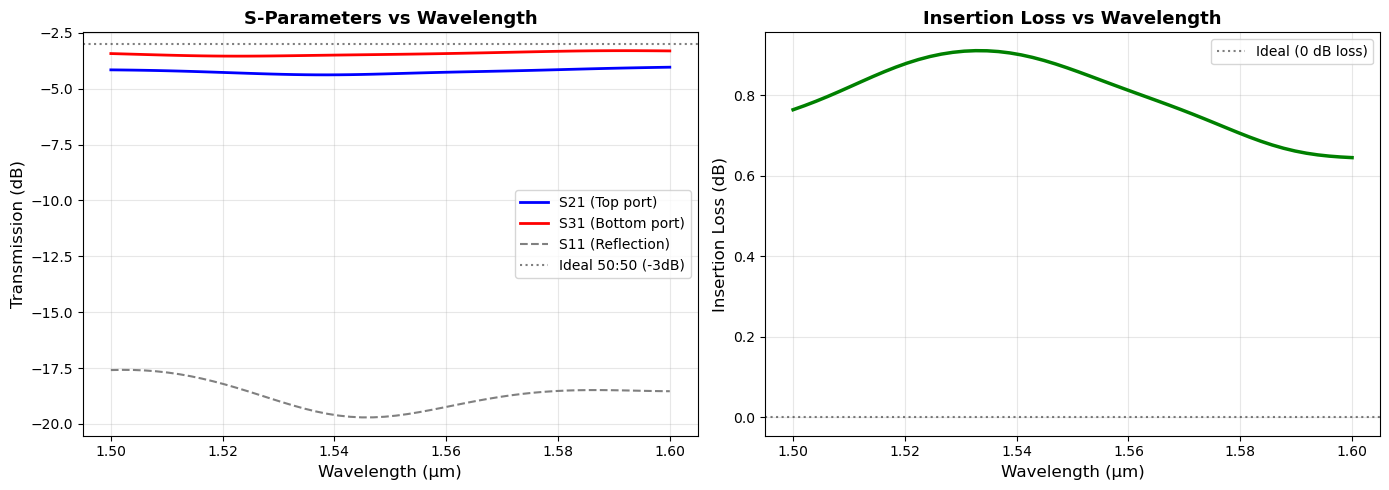

In [19]:
# Calculate insertion loss from S-parameters
sp = np.load(s)

# Extract S-parameters at center wavelength
wavelengths_sim = sp['wavelengths']
center_idx = len(wavelengths_sim) // 2

# S21 and S31 (transmission from port 1 to ports 2 and 3)
S21 = sp['o1@0,o2@0'][center_idx]  # Port 1 to Port 2 (top)
S31 = sp['o1@0,o3@0'][center_idx]  # Port 1 to Port 3 (bottom)
S11 = sp['o1@0,o1@0'][center_idx]  # Reflection at Port 1

# Calculate power transmission (magnitude squared)
T21 = np.abs(S21)**2  # Transmission to port 2
T31 = np.abs(S31)**2  # Transmission to port 3
R11 = np.abs(S11)**2  # Reflection

# Total transmission
total_transmission = T21 + T31

# Insertion loss (in dB)
insertion_loss_dB = -10 * np.log10(total_transmission)

# Individual port losses
S21_dB = 10 * np.log10(T21)
S31_dB = 10 * np.log10(T31)
S11_dB = 10 * np.log10(R11)

print("="*70)
print("S-PARAMETER ANALYSIS (at λ = {:.3f} μm)".format(wavelengths_sim[center_idx]))
print("="*70)
print("\nTransmission Coefficients:")
print(f"  S21 (to top port):    {S21_dB:.2f} dB  ({T21:.4f} or {T21*100:.2f}%)")
print(f"  S31 (to bottom port): {S31_dB:.2f} dB  ({T31:.4f} or {T31*100:.2f}%)")
print(f"\nReflection:")
print(f"  S11 (reflection):     {S11_dB:.2f} dB  ({R11:.4f} or {R11*100:.2f}%)")
print(f"\nTotal Performance:")
print(f"  Total Transmission:   {total_transmission:.4f} ({total_transmission*100:.2f}%)")
print(f"  Insertion Loss:       {insertion_loss_dB:.2f} dB")
print(f"\nPower Balance Check:")
print(f"  Transmitted + Reflected: {(total_transmission + R11)*100:.2f}%")
print(f"  Lost (scattering/absorption): {(1 - total_transmission - R11)*100:.2f}%")
print(f"\nSplitting Performance:")
imbalance = abs(S21_dB - S31_dB)
print(f"  Imbalance:            {imbalance:.2f} dB")
if imbalance < 0.5:
    print(f"  Quality:              Excellent (<0.5 dB)")
elif imbalance < 1.0:
    print(f"  Quality:              Good (<1 dB)")
else:
    print(f"  Quality:              Fair (>{imbalance:.1f} dB)")
print("="*70)

# Plot S-parameters vs wavelength
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Transmission in dB
ax = axes[0]
S21_dB_all = 10 * np.log10(np.abs(sp['o1@0,o2@0'])**2)
S31_dB_all = 10 * np.log10(np.abs(sp['o1@0,o3@0'])**2)
S11_dB_all = 10 * np.log10(np.abs(sp['o1@0,o1@0'])**2)

ax.plot(wavelengths_sim, S21_dB_all, 'b-', linewidth=2, label='S21 (Top port)')
ax.plot(wavelengths_sim, S31_dB_all, 'r-', linewidth=2, label='S31 (Bottom port)')
ax.plot(wavelengths_sim, S11_dB_all, 'gray', linewidth=1.5, linestyle='--', label='S11 (Reflection)')
ax.axhline(y=-3, color='k', linestyle=':', alpha=0.5, label='Ideal 50:50 (-3dB)')
ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Transmission (dB)', fontsize=12)
ax.set_title('S-Parameters vs Wavelength', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Insertion Loss
ax = axes[1]
total_trans_all = np.abs(sp['o1@0,o2@0'])**2 + np.abs(sp['o1@0,o3@0'])**2
insertion_loss_all = -10 * np.log10(total_trans_all)

ax.plot(wavelengths_sim, insertion_loss_all, 'g-', linewidth=2.5)
ax.axhline(y=0, color='k', linestyle=':', alpha=0.5, label='Ideal (0 dB loss)')
ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Insertion Loss (dB)', fontsize=12)
ax.set_title('Insertion Loss vs Wavelength', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('insertion_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# print("\nPlot saved as 'insertion_loss_analysis.png'")

For generic device from gdsfactory

In [20]:
# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

resolution = 20
dpml = 1
pad = 1
s_ybranch = gm.write_sparameters_meep_mpi(
        ybranch,
        cores=8,
        xmargin_left=1,
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        port_source_names=['o1', 'o2', 'o3'],
        port_source_modes={'o1':[0], 'o2':[0], 'o3':[0]},
        port_modes=[0],
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/y_branch_sparameters.npz'),
        tpml=dpml,
        resolution=resolution,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=-0.5,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        # port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        material_name_to_meep=dict(si=core_material),
        is_3d=False,
        overwrite=False,
        run=False
        )

2025-12-08 23:30:54.555 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/y_branch_sparameters.npz') already exists


S-PARAMETER ANALYSIS (at λ = 1.551 μm)

Transmission Coefficients:
  S21 (to top port):    -3.28 dB  (0.4698 or 46.98%)
  S31 (to bottom port): -3.28 dB  (0.4698 or 46.98%)

Reflection:
  S11 (reflection):     -33.72 dB  (0.0004 or 0.04%)

Total Performance:
  Total Transmission:   0.9395 (93.95%)
  Insertion Loss:       0.27 dB

Power Balance Check:
  Transmitted + Reflected: 94.00%
  Lost (scattering/absorption): 6.00%

Splitting Performance:
  Imbalance:            0.00 dB
  Quality:              Excellent (<0.5 dB)


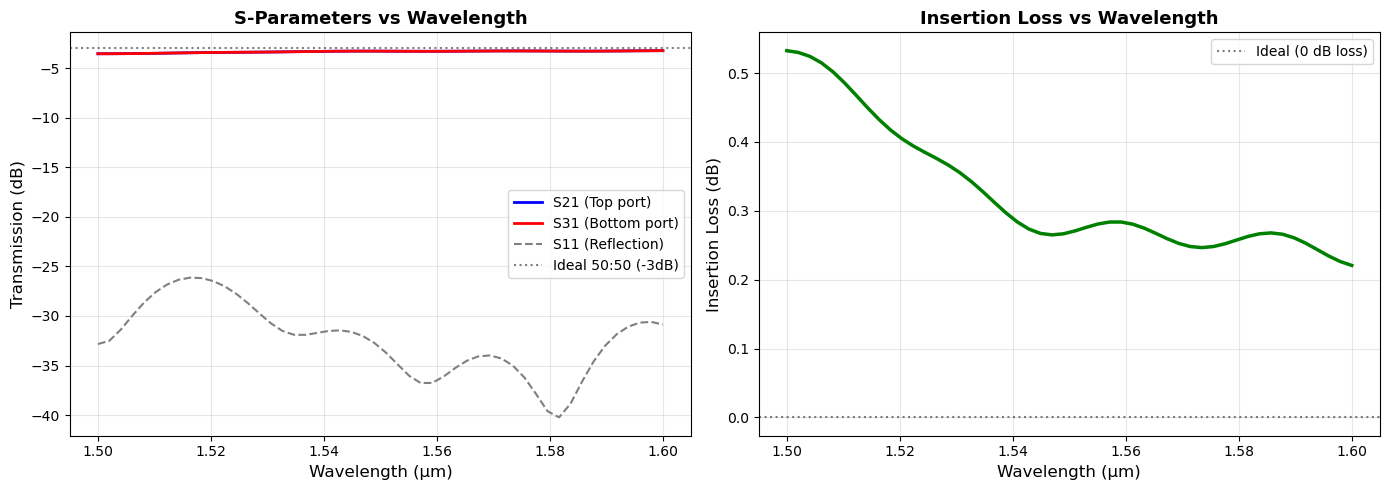

In [21]:
# Calculate insertion loss from S-parameters
sp = np.load(s_ybranch)

# Extract S-parameters at center wavelength
wavelengths_sim = sp['wavelengths']
center_idx = len(wavelengths_sim) // 2

# S21 and S31 (transmission from port 1 to ports 2 and 3)
S21 = sp['o1@0,o2@0'][center_idx]  # Port 1 to Port 2 (top)
S31 = sp['o1@0,o3@0'][center_idx]  # Port 1 to Port 3 (bottom)
S11 = sp['o1@0,o1@0'][center_idx]  # Reflection at Port 1

# Calculate power transmission (magnitude squared)
T21 = np.abs(S21)**2  # Transmission to port 2
T31 = np.abs(S31)**2  # Transmission to port 3
R11 = np.abs(S11)**2  # Reflection

# Total transmission
total_transmission = T21 + T31

# Insertion loss (in dB)
insertion_loss_dB = -10 * np.log10(total_transmission)

# Individual port losses
S21_dB = 10 * np.log10(T21)
S31_dB = 10 * np.log10(T31)
S11_dB = 10 * np.log10(R11)

print("="*70)
print("S-PARAMETER ANALYSIS (at λ = {:.3f} μm)".format(wavelengths_sim[center_idx]))
print("="*70)
print("\nTransmission Coefficients:")
print(f"  S21 (to top port):    {S21_dB:.2f} dB  ({T21:.4f} or {T21*100:.2f}%)")
print(f"  S31 (to bottom port): {S31_dB:.2f} dB  ({T31:.4f} or {T31*100:.2f}%)")
print(f"\nReflection:")
print(f"  S11 (reflection):     {S11_dB:.2f} dB  ({R11:.4f} or {R11*100:.2f}%)")
print(f"\nTotal Performance:")
print(f"  Total Transmission:   {total_transmission:.4f} ({total_transmission*100:.2f}%)")
print(f"  Insertion Loss:       {insertion_loss_dB:.2f} dB")
print(f"\nPower Balance Check:")
print(f"  Transmitted + Reflected: {(total_transmission + R11)*100:.2f}%")
print(f"  Lost (scattering/absorption): {(1 - total_transmission - R11)*100:.2f}%")
print(f"\nSplitting Performance:")
imbalance = abs(S21_dB - S31_dB)
print(f"  Imbalance:            {imbalance:.2f} dB")
if imbalance < 0.5:
    print(f"  Quality:              Excellent (<0.5 dB)")
elif imbalance < 1.0:
    print(f"  Quality:              Good (<1 dB)")
else:
    print(f"  Quality:              Fair (>{imbalance:.1f} dB)")
print("="*70)

# Plot S-parameters vs wavelength
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Transmission in dB
ax = axes[0]
S21_dB_all = 10 * np.log10(np.abs(sp['o1@0,o2@0'])**2)
S31_dB_all = 10 * np.log10(np.abs(sp['o1@0,o3@0'])**2)
S11_dB_all = 10 * np.log10(np.abs(sp['o1@0,o1@0'])**2)

ax.plot(wavelengths_sim, S21_dB_all, 'b-', linewidth=2, label='S21 (Top port)')
ax.plot(wavelengths_sim, S31_dB_all, 'r-', linewidth=2, label='S31 (Bottom port)')
ax.plot(wavelengths_sim, S11_dB_all, 'gray', linewidth=1.5, linestyle='--', label='S11 (Reflection)')
ax.axhline(y=-3, color='k', linestyle=':', alpha=0.5, label='Ideal 50:50 (-3dB)')
ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Transmission (dB)', fontsize=12)
ax.set_title('S-Parameters vs Wavelength', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Insertion Loss
ax = axes[1]
total_trans_all = np.abs(sp['o1@0,o2@0'])**2 + np.abs(sp['o1@0,o3@0'])**2
insertion_loss_all = -10 * np.log10(total_trans_all)

ax.plot(wavelengths_sim, insertion_loss_all, 'g-', linewidth=2.5)
ax.axhline(y=0, color='k', linestyle=':', alpha=0.5, label='Ideal (0 dB loss)')
ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Insertion Loss (dB)', fontsize=12)
ax.set_title('Insertion Loss vs Wavelength', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('insertion_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# print("\nPlot saved as 'insertion_loss_analysis.png'")